In [ ]:
pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 21.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import os
import numpy as np
from IPython.display import Audio
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout, Lambda
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.utils import timeseries_dataset_from_array
from itertools import groupby
tf.get_logger().setLevel('ERROR')

In [ ]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

Dataset URL: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
License(s): CC-BY-NC-SA-4.0
 99% 597M/604M [00:03<00:00, 202MB/s]
100% 604M/604M [00:03<00:00, 176MB/s]


In [ ]:
!unzip /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

Archive:  /content/z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: Forest Recordings/recording_00.mp3  
  inflating: Forest Recordings/recording_01.mp3  
  inflating: Forest Recordings/recording_02.mp3  
  inflating: Forest Recordings/recording_03.mp3  
  inflating: Forest Recordings/recording_04.mp3  
  inflating: Forest Recordings/recording_05.mp3  
  inflating: Forest Recordings/recording_06.mp3  
  inflating: Forest Recordings/recording_07.mp3  
  inflating: Forest Recordings/recording_08.mp3  
  inflating: Forest Recordings/recording_09.mp3  
  inflating: Forest Recordings/recording_10.mp3  
  inflating: Forest Recordings/recording_11.mp3  
  inflating: Forest Recordings/recording_12.mp3  
  inflating: Forest Recordings/recording_13.mp3  
  inflating: Forest Recordings/recording_14.mp3  
  inflating: Forest Recordings/recording_15.mp3  
  inflating: Forest Recordings/recording_16.mp3  
  inflating: Forest Recordings/recording_17.mp3  
  inflating: Forest Recordings

# Data Preparation

Load audio file paths

In [ ]:
POS = '/content/Parsed_Capuchinbird_Clips'
pos = tf.data.Dataset.list_files(POS+'/*.wav') #find all .wav files in directory

NEG = '/content/Parsed_Not_Capuchinbird_Clips'
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
print('Positive:', pos.as_numpy_iterator().next())
print('Negative:', neg.as_numpy_iterator().next())

Positive: b'/content/Parsed_Capuchinbird_Clips/XC456236-2.wav'
Negative: b'/content/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-22.wav'


View sample data

In [ ]:
def play_audio(file_path):
    file_path = file_path.decode('utf-8')
    return Audio(file_path)

In [ ]:
#sample positive audio
play_audio(pos.as_numpy_iterator().next())

In [ ]:
#sample negative audio
play_audio(neg.as_numpy_iterator().next())

Load data from audio files

In [ ]:
# Function to load the audio file using librosa
@tf.py_function(Tout=tf.float32)
def load_wav_16k(file_path):
    file_path = file_path.numpy().decode('utf-8')  # Convert tf.Tensor to string
    data, rate = librosa.load(file_path, sr=16000)
    return data

In [ ]:
pos_data = pos.map(load_wav_16k)
neg_data = neg.map(load_wav_16k)

View stats on audio data

In [ ]:
def get_length(data):
    return len(data)

length = pos_data.map(get_length)
lengths = list(length.as_numpy_iterator())
stats = (tf.reduce_mean(lengths), tf.reduce_min(lengths), tf.reduce_max(lengths))

In [ ]:
print(f'Mean no. of values: {stats[0]}\nMin no. of values: {stats[1]}\nMax no. of values: {stats[2]}')

Mean no. of values: 54156
Min no. of values: 32000
Max no. of values: 80000


Get spectrograms from audio data

In [ ]:
def process_data(data, label):
    data_3s = data[:48000] #select 48000 values (3 seconds from audio clip)
    num_pad = 48000 - len(data_3s) #number to pad data up to if less than 48000
    pad_data_3s = tf.pad(data_3s, [[0, num_pad]])
    spectrogram = tf.signal.stft(pad_data_3s, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)#expand to have extra channel to be compatible with CNN
    return spectrogram, label

def show_spectrogram(spectrogram):
    plt.figure(figsize=(30,20))
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.show()

In [ ]:
proc_pos = pos_data.map(lambda x: process_data(x, 1))
proc_neg = neg_data.map(lambda x: process_data(x, 0))
dataset = proc_pos.concatenate(proc_neg)

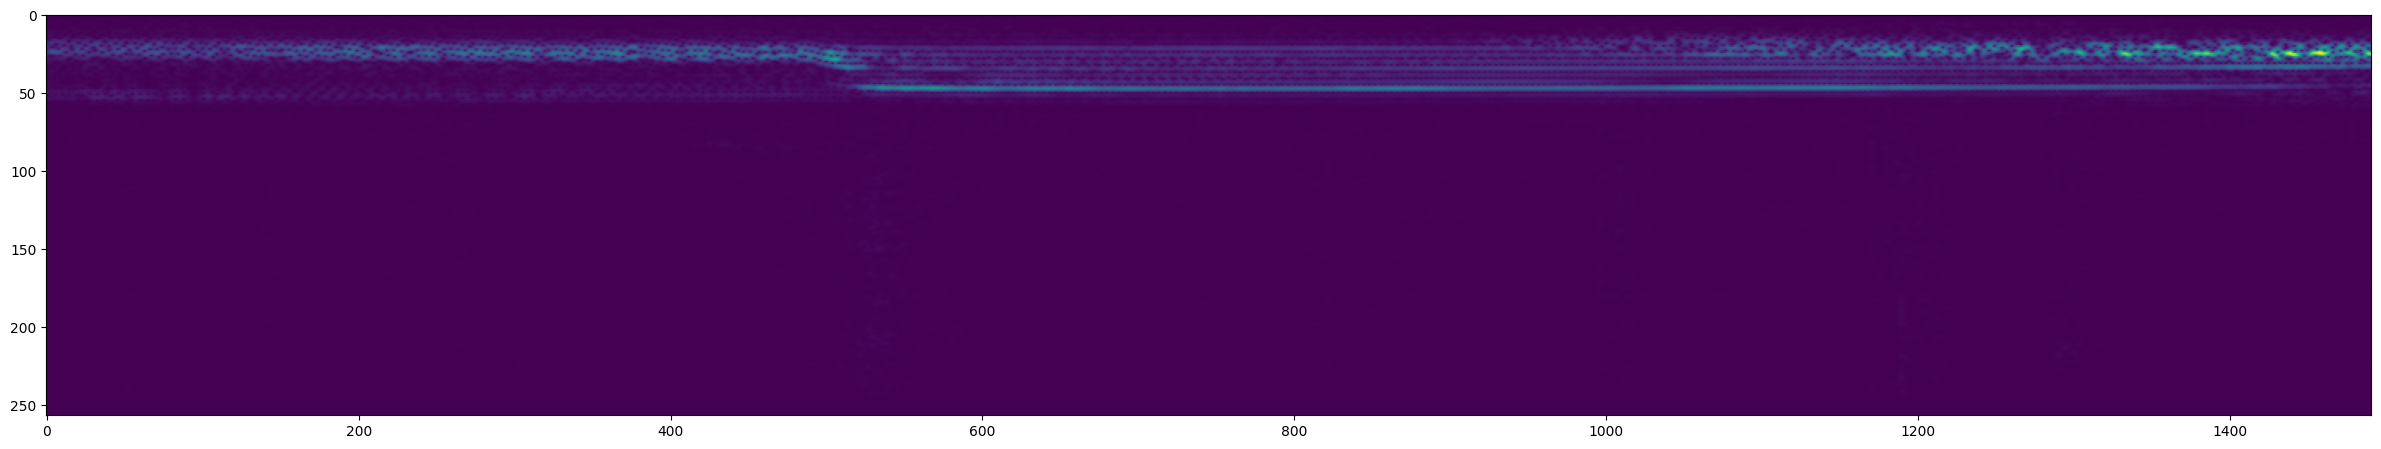

In [ ]:
#sample spectrogram for positive audio data
samp_spec = proc_pos.as_numpy_iterator().next()[0]
show_spectrogram(samp_spec)

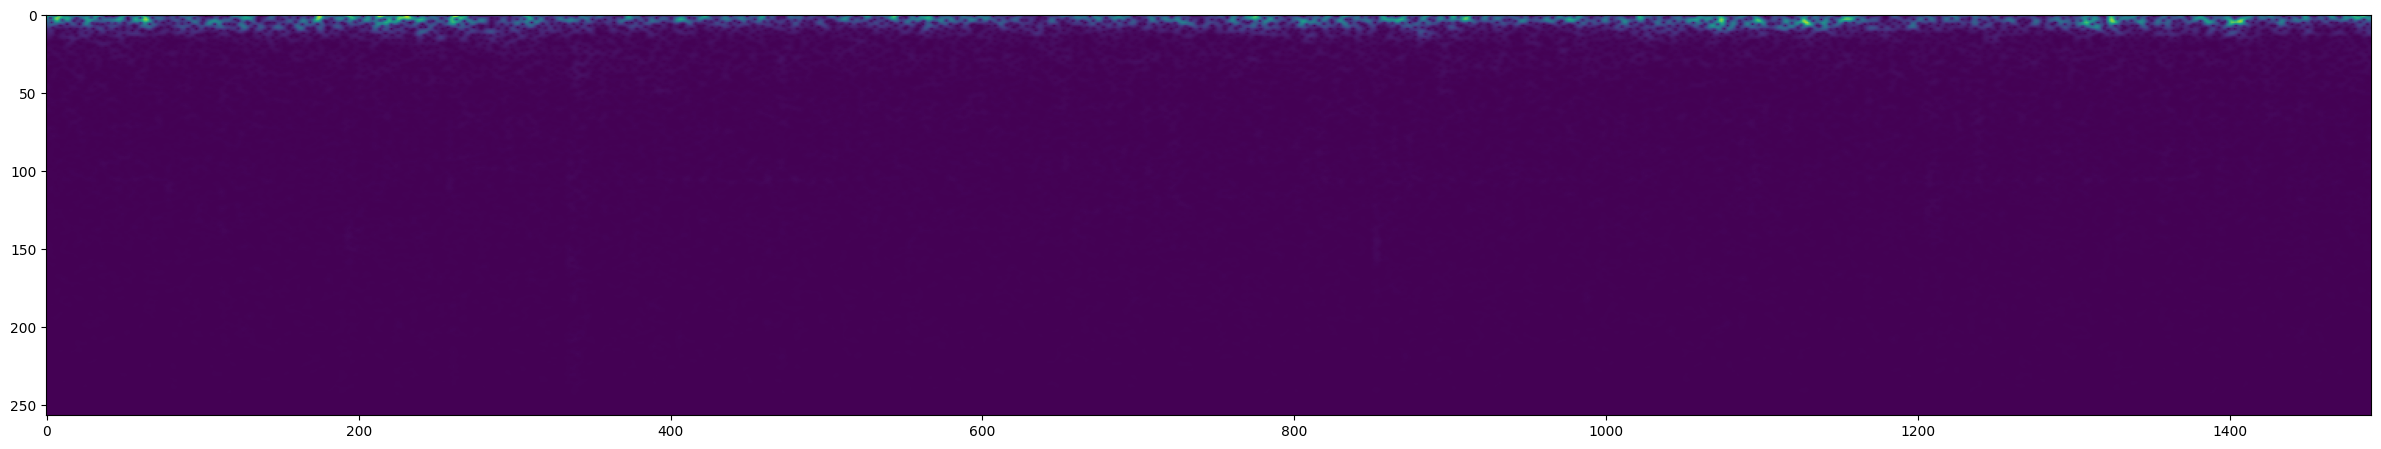

In [ ]:
#sample spectrogram for negative audio data
samp_spec = proc_neg.as_numpy_iterator().next()[0]
show_spectrogram(samp_spec)

Create data pipeline and split into train/test

In [ ]:
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(-1)
split = np.ceil(len(dataset) * 0.7)
train = dataset.take(split)
test = dataset.skip(split).take(len(dataset) - split)

In [ ]:
len(train), len(test)

(36, 15)

In [ ]:
sample, label = train.as_numpy_iterator().next()
sample.shape

(16, 1491, 257, 1)

# Build model

In [ ]:
def grayscale_to_rgb(x): #convert to 3 channels for EfficientNet
    return tf.image.grayscale_to_rgb(x)

In [ ]:
base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(1491, 257, 3))
base_model.trainable = False

model = Sequential([
    Input(shape=(1491, 257, 1)),
    Lambda(grayscale_to_rgb),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
  ])

model.summary()

52606240/52606240 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1491, 257, 3)      0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 47, 9, 1536)       12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                         

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[Recall(), Precision()])
history = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 120s 3s/step - loss: 0.4471 - recall: 0.4067 - precision: 0.7922 - val_loss: 0.3054 - val_recall: 0.5263 - val_precision: 0.9677
Epoch 2/4
36/36 [==============================] - 107s 3s/step - loss: 0.3466 - recall: 0.6497 - precision: 0.9027 - val_loss: 0.2582 - val_recall: 0.7857 - val_precision: 0.8800
Epoch 3/4
36/36 [==============================] - 107s 3s/step - loss: 0.3154 - recall: 0.6993 - precision: 0.8699 - val_loss: 0.2340 - val_recall: 0.7606 - val_precision: 0.9643
Epoch 4/4
36/36 [==============================] - 104s 3s/step - loss: 0.3168 - recall: 0.6733 - precision: 0.8080 - val_loss: 0.2148 - val_recall: 0.7222 - val_precision: 0.9070


In [ ]:
history.history

{'loss': [0.4471192955970764,
  0.34659343957901,
  0.31537848711013794,
  0.31679168343544006],
 'recall': [0.40666666626930237,
  0.6496815085411072,
  0.6993464231491089,
  0.6733333468437195],
 'precision': [0.7922077775001526,
  0.9026548862457275,
  0.869918704032898,
  0.8080000281333923],
 'val_loss': [0.3054424226284027,
  0.25824519991874695,
  0.23398485779762268,
  0.21479760110378265],
 'val_recall': [0.5263158082962036,
  0.7857142686843872,
  0.7605633735656738,
  0.7222222089767456],
 'val_precision': [0.9677419066429138,
  0.8799999952316284,
  0.9642857313156128,
  0.9069767594337463]}

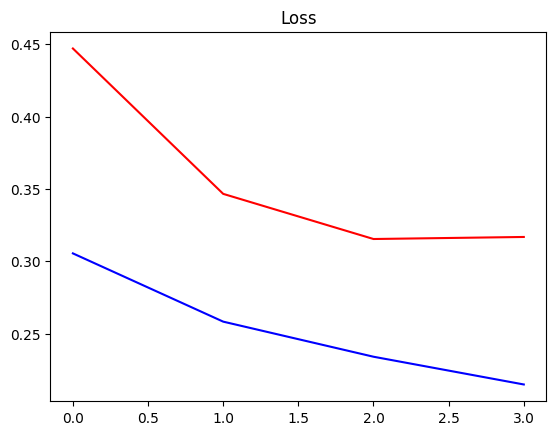

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

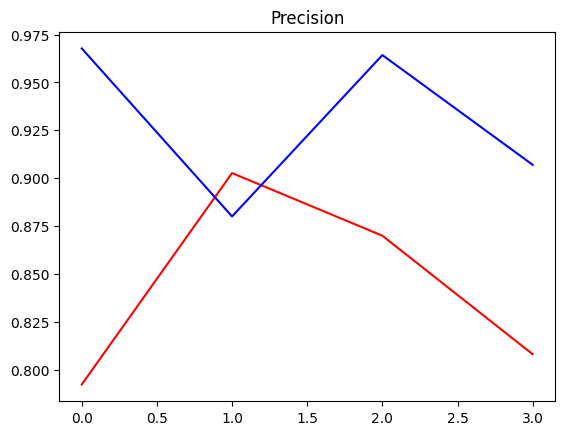

In [ ]:
plt.title('Precision')
plt.plot(history.history['precision'], 'r')
plt.plot(history.history['val_precision'], 'b')
plt.show()

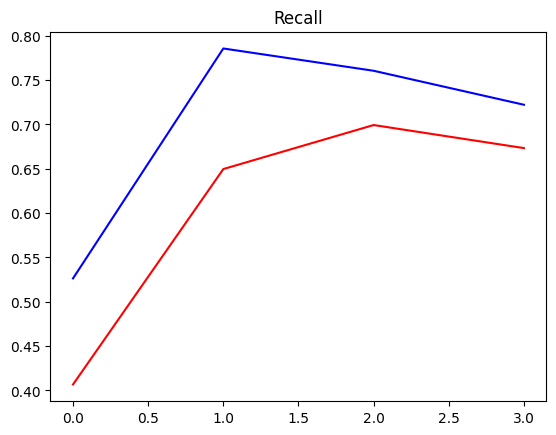

In [ ]:
plt.title('Recall')
plt.plot(history.history['recall'], 'r')
plt.plot(history.history['val_recall'], 'b')
plt.show()

In [ ]:
x_test,y_test=test.as_numpy_iterator().next()


In [ ]:
y_test.shape

(16,)

In [ ]:
yhat = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [ ]:
yhat

array([[0.06995652],
       [0.04790603],
       [0.04790545],
       [0.0457822 ],
       [0.06613967],
       [0.06617243],
       [0.04843712],
       [0.06753805],
       [0.05933507],
       [0.09493137],
       [0.07764094],
       [0.9017324 ],
       [0.01593953],
       [0.9481688 ],
       [0.07302376],
       [0.06578701]], dtype=float32)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
y_test

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
import librosa

def load_mp3_16k_mono(filename):
    # Load the file with librosa
    wav, _ = librosa.load(filename, sr=16000, mono=True)
    return wav


In [ ]:
mp3=os.path.join("/content/Forest Recordings/recording_00.mp3")

In [ ]:
wav=load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
len(audio_slices)

60

In [ ]:
samples.shape

(1, 48000)

In [ ]:
def prepossing_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(prepossing_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat=model.predict(audio_slices)
yhat=[1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 [==============================] - 7s 7s/step


In [ ]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:

from itertools import groupby


In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [ ]:
result={}
for file in os.listdir("/content/Forest Recordings"):
  FILEPATH=os.path.join("/content/Forest Recordings",file)
  wav=load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=480)
  audio_slices = audio_slices.map(prepossing_mp3)
  audio_slices = audio_slices.batch(64)
  yhat=model.predict(audio_slices)
  result[file]= yhat

1/1 [==============================] - 6s 6s/step


In [ ]:
result

{'recording_73.mp3': array([[0.07404169],
        [0.14383961],
        [0.17200018],
        [0.11863808],
        [0.08796045],
        [0.16493161],
        [0.17776656],
        [0.12183591],
        [0.07132204],
        [0.13669096],
        [0.14199713],
        [0.15609078],
        [0.15857616],
        [0.14101383],
        [0.13922304],
        [0.06877013],
        [0.15417686],
        [0.12613247],
        [0.15683539],
        [0.13722803],
        [0.09872114],
        [0.14276308],
        [0.14193778],
        [0.1454812 ],
        [0.09198908],
        [0.15478091],
        [0.1167329 ],
        [0.11752178],
        [0.13483106],
        [0.11533912],
        [0.10818127],
        [0.07357852],
        [0.06900784],
        [0.10685126],
        [0.11605646],
        [0.12069059],
        [0.09422488],
        [0.10014536],
        [0.05448049],
        [0.10734332],
        [0.11266296],
        [0.12566978],
        [0.06206181],
        [0.09764378],
        [0.1

In [ ]:
class_preds = {}
for file, logits in result.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_preds

{'recording_73.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_11.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_87.mp3': [0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0],
 'recording_52.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    # print(file, scores)
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_73.mp3': 0,
 'recording_11.mp3': 2,
 'recording_87.mp3': 19,
 'recording_52.mp3': 0,
 'recording_12.mp3': 0,
 'recording_63.mp3': 2,
 'recording_26.mp3': 2,
 'recording_54.mp3': 3,
 'recording_46.mp3': 4,
 'recording_35.mp3': 0,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_62.mp3': 0,
 'recording_45.mp3': 3,
 'recording_75.mp3': 1,
 'recording_93.mp3': 5,
 'recording_71.mp3': 5,
 'recording_23.mp3': 3,
 'recording_77.mp3': 3,
 'recording_85.mp3': 0,
 'recording_00.mp3': 5,
 'recording_79.mp3': 0,
 'recording_99.mp3': 5,
 'recording_21.mp3': 1,
 'recording_25.mp3': 0,
 'recording_04.mp3': 4,
 'recording_58.mp3': 0,
 'recording_69.mp3': 1,
 'recording_86.mp3': 4,
 'recording_98.mp3': 20,
 'recording_72.mp3': 4,
 'recording_96.mp3': 1,
 'recording_88.mp3': 0,
 'recording_24.mp3': 0,
 'recording_03.mp3': 0,
 'recording_36.mp3': 0,
 'recording_55.mp3': 0,
 'recording_90.mp3': 0,
 'recording_14.mp3': 0,
 'recording_38.mp3': 1,
 'recording_05.mp3': 0,
 'recording_02

In [ ]:
import csv

In [ ]:
with open('results.csv','w',newline="") as f:
  writer=csv.writer(f,delimiter=",")
  writer.writerow(['recording','capuchin_calls'])
  for key,value in postprocessed.items():
    writer.writerow([key,value])